In [4]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

## A/B Testing

Is there a difference in baby weights for mothers who smoke and mothers who don't?

In [5]:
baby = Table.read_table('http://inferentialthinking.com/notebooks/baby.csv')
baby.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


In [6]:
baby.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


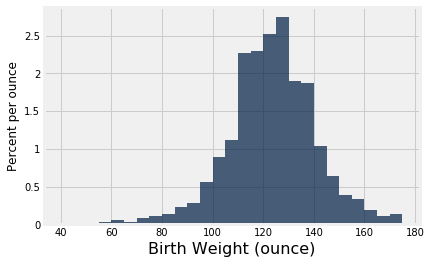

In [9]:
weight_bins = np.arange(40, 180, 5)
baby.where('Maternal Smoker', False).hist('Birth Weight', bins=weight_bins, unit='ounce')

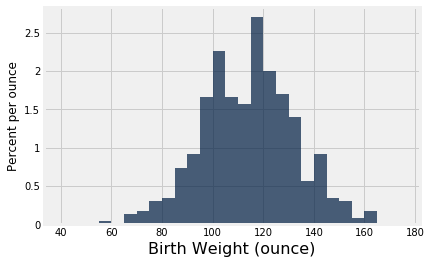

In [10]:
baby.where('Maternal Smoker', True).hist('Birth Weight', bins=weight_bins, unit='ounce')

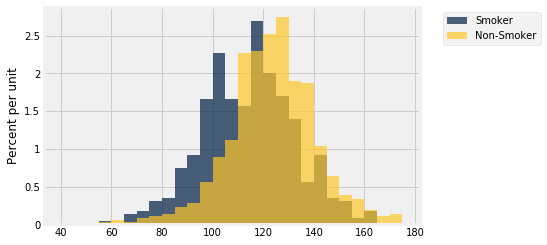

In [11]:
baby.where('Maternal Smoker', False).bin('Birth Weight', bins=weight_bins).join(
    'bin', baby.where('Maternal Smoker', True).bin('Birth Weight', bins=weight_bins)
).relabeled(1, 'Non-Smoker').relabeled(2, 'Smoker').hist(bin_column='bin')

In [28]:
smoke_weight = baby.select(5, 0)
means = smoke_weight.group(0, np.mean)
means.column(1).item(0) - means.column(1).item(1)

9.266142572024918

In [29]:
def difference_in_means(t):
    means = t.group(0, np.mean)
    return means.column(1).item(0) - means.column(1).item(1)

difference_in_means(smoke_weight)

9.266142572024918

In [30]:
def permutation_test_means(table, variable, classes, repetitions, unit=None):
    """Test whether two numerical samples 
    come from the same underlying distribution, 
    using the absolute difference between the means.
    table: name of table containing the sample
    variable: label of column containing the numerical variable 
    classes: label of column containing names of the two samples
    repetitions: number of random permutations
    
    variable -- Label for a numerical variable in table
    classes -- Label for a two-category (A & B) variable in table
    """
    
    t = table.select(classes, variable)
    observed = abs(difference_in_means(t))
    
    # Assuming the null is true, randomly permute the variable 
    # and collect all the generated test statistics
    stats = make_array()
    for i in np.arange(repetitions):
        shuffled_var = t.select(variable).sample(with_replacement=False).column(0)
        shuffled = t.select(classes).with_column('Shuffled Variable', shuffled_var)
        new_stat = abs(difference_in_means(shuffled))
        stats = np.append(stats, new_stat)
    
    # Find the empirical P-value:
    p = np.count_nonzero(stats >= observed) / repetitions

    # Draw the empirical histogram of the tvd's generated under the null, 
    # and compare with the value observed in the original sample
    Table().with_column('Test Statistic', stats).hist(unit=unit)
    plt.title('Empirical Distribution Under the Null')
    print('Observed statistic:', observed)
    print('Empirical P-value:', p)

Observed statistic: 9.266142572024918
Empirical P-value: 0.0


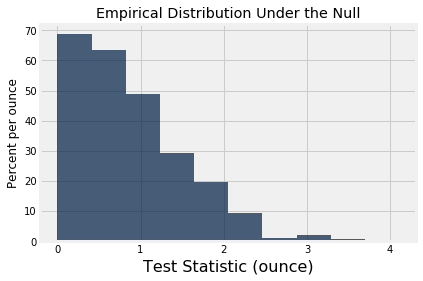

In [31]:
permutation_test_means(baby, 'Birth Weight', 'Maternal Smoker', 1000, 'ounce')

## Effect Size

In [32]:
def bootstrap_ci_means(table, variable, classes, repetitions, unit=None):
    """Bootstrap approximate 95% confidence interval
    for the difference between the means of the two classes
    in the population
    """
    
    t = table.select(classes, variable)
    
    stats = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = t.sample()
        new_stat = difference_in_means(bootstrap_sample)
        stats = np.append(stats, new_stat)
        
    left = percentile(2.5, stats)
    right = percentile(97.5, stats)
    
    Table().with_column('Difference Between Means', stats).hist(unit=unit)
    plt.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8)
    print('Approximate 95% CI for the difference between means:')
    print(left, 'to', right)

Approximate 95% CI for the difference between means:
7.17999471435 to 11.4574537327


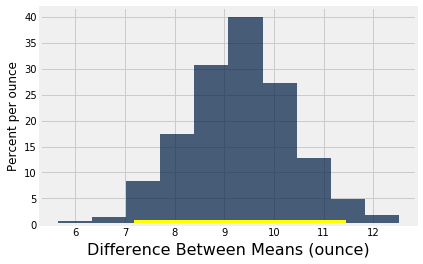

In [33]:
bootstrap_ci_means(baby, 'Birth Weight', 'Maternal Smoker', 1000, 'ounce')

In [34]:
baby.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


Approximate 95% CI for the difference between means:
0.12971301633 to 1.45591799924


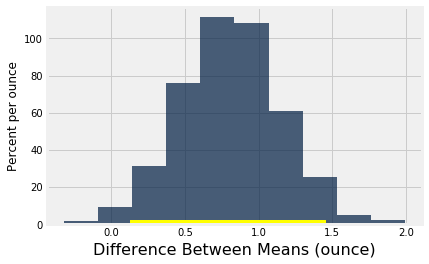

In [36]:
bootstrap_ci_means(baby, 'Maternal Age', 'Maternal Smoker', 1000, 'ounce')

In [37]:
baby.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


Approximate 95% CI for the difference between means:
-0.397438887358 to 0.20812053836


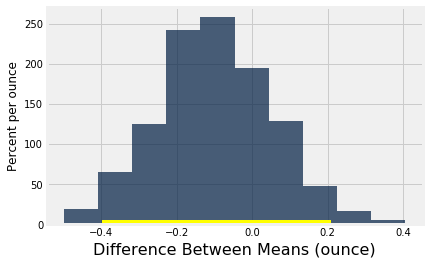

In [39]:
bootstrap_ci_means(baby, 'Maternal Height', 'Maternal Smoker', 1000, 'ounce')

## RCTs

In [43]:
bta = Table.read_table('http://inferentialthinking.com/notebooks/bta.csv')
bta.show(3)

Group,Result
Control,1
Control,1
Control,0


In [44]:
bta.group('Group', np.mean)

Group,Result mean
Control,0.125
Treatment,0.6


Observed statistic: 0.475
Empirical P-value: 0.013


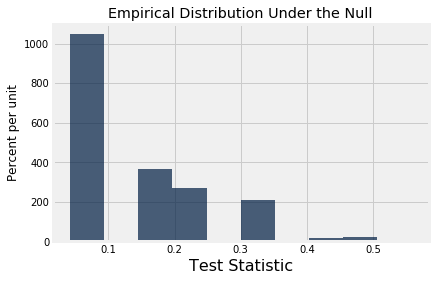

In [45]:
permutation_test_means(bta, 'Result', 'Group', 1000)

Approximate 95% CI for the difference between means:
-0.75 to -0.154166666667


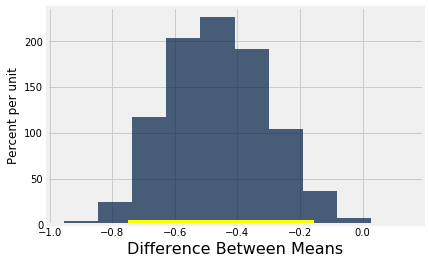

In [46]:
bootstrap_ci_means(bta, 'Result', 'Group', 1000)